In [1]:
%tensorflow_version  2.x
! pip install -q keras==2.3.0

     |████████████████████████████████| 378kB 3.4MB/s 


In [2]:
# Per sapere che GPU il signor Google ci regala sta volta

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4099145616854509809, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 9715946385236660674
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 11901432304237956466
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15701463552
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2176681347524767443
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [3]:
! pip install pyGPGO

  Created wheel for pyGPGO: filename=pyGPGO-0.4.0.dev1-cp36-none-any.whl size=19866 sha256=6c3d362d1ea2b86bf749f192dcee70f9da519a9363a66e06452a4e19179f150e
  Stored in directory: /root/.cache/pip/wheels/d1/27/04/c4fa3bfe194d36e3cd51542132f43415a6813114a5e8301acb
Successfully built pyGPGO


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import make_scorer, classification_report
from sklearn.model_selection import cross_val_score, KFold, train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.utils import class_weight



from xgboost.sklearn import XGBClassifier
import xgboost

from keras import models, layers, optimizers, metrics, callbacks


from keras.wrappers.scikit_learn import KerasClassifier


from pyGPGO.surrogates.RandomForest import RandomForest
from pyGPGO.GPGO import GPGO
from pyGPGO.acquisition import Acquisition


import requests

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

# Load Data

In [0]:
data = pd.read_csv('/content/drive/My Drive/progetto_aml/dataset/train_prepocessed.csv')

# Funzioni utilli

In [0]:
# Funzioni per calcolare ndcg

def dcg_score(y_true, y_score, k=5):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)


def ndcg_score(ground_truth, predictions, k=5):
    lb = LabelBinarizer()
    lb.fit(range(len(predictions) ))
    T = lb.transform(ground_truth)

    scores = []

    # Iterate over each y_true and compute the DCG score
    for y_true, y_score in zip(T, predictions):
        actual = dcg_score(y_true, y_score, k)
        best = dcg_score(y_true, y_true, k)
        score = float(actual) / float(best)
        scores.append(score)

    return np.mean(scores)



ndcg_scorer = make_scorer(ndcg_score, needs_proba=True, k=5)

In [0]:
# Top_n accuracy

def top_n_accuracy(y_true, y_pred_prob, n = 5):
    topn = np.argsort(y_pred_prob, axis = 1)[:,-n:]
    acc = np.mean(np.array([1 if y_true[k] in topn[k] else 0 for k in range(len(topn))]))
    return(acc)

In [0]:
# Messaggio su Telegram

def telegram_bot_sendtext(bot_message):
    
    bot_token = '937044171:AAGGDmJcUTkkvDaOwcKrnHUyj9XUND7d52A'
    bot_chatID = '166942243'
    send_text = 'https://api.telegram.org/bot' + bot_token + '/sendMessage?chat_id=' + bot_chatID + '&parse_mode=Markdown&text=' + str(bot_message)

    response = requests.get(send_text)

    return response.json()

In [0]:
def resultDataframe(hyperparams,score, initial):
  result = pd.DataFrame(hyperparams,columns=['lr','max_depth', 'n_estimator', 'max_delta_step'])
  result['ndcg'] = score
  result['phase']="increment"
  result.loc[0:initial-1,'phase']='initial'
  return result

## AutoML XGboost

In [0]:
data_prova = data.copy()

In [0]:
data_prova.drop("id", axis = 1, inplace = True)

In [0]:
X_train_cval, X_test = train_test_split(data_prova, test_size = 0.1, stratify = data_prova["country_destination"], random_state = 42)

In [0]:
y_train = X_train_cval.pop("country_destination")
y_test = X_test.pop("country_destination")

In [0]:
Kfold = StratifiedKFold(5, shuffle=True, random_state=42)

In [0]:
label_encoder = LabelEncoder()
encoded_y_train = label_encoder.fit_transform(y_train)
encoded_y_test = label_encoder.fit_transform(y_test)

In [0]:
range_lr = [0.01, 1]
n_max_depth = [1, 20]
n_estimators = [1, 100] 
n_max_delta = [1, 10]
param = {'lr': ('cont', range_lr), 
         'n_max_depth': ('int', n_max_depth),
         'n_estimators' : ('int', n_estimators),
         'n_max_delta' : ('int', n_max_delta)}

rf_model = RandomForest()

f_acq = Acquisition(mode = "ExpectedImprovement")
f_acq1 = Acquisition(mode = "ProbabilityImprovement") 

In [0]:
def compute_ndcg(lr, n_max_depth, n_estimators, n_max_delta):
    xgb = XGBClassifier(max_depth = int(n_max_depth), learning_rate = lr, n_estimators=int(n_estimators),
                        objective = 'multi:softprob', colsample_bytree = 1, 
                        seed=42, n_jobs = -1, tree_method = "gpu_hist", max_delta_step = int(n_max_delta), verbosity=0)
    
    cval_score = []
    i = 1
    for train_index, test_index in Kfold.split(X_train_cval, encoded_y_train):
        
        X_train, X_val = X_train_cval.values[train_index], X_train_cval.values[test_index]
        y_train, y_val = encoded_y_train[train_index], encoded_y_train[test_index]

        xgb.fit(X_train, y_train, 
                verbose = 0)
        
        y_pred_prob = xgb.predict_proba(X_val)
        actual = ndcg_score(y_val, y_pred_prob, k = 5)
        cval_score.append(actual)
        print("Numero Fold: " + str(i))
        i = i+1


    return np.mean(cval_score)

In [0]:
# Funzione di acquisizione expected improvement
np.random.seed(42)

SMBO_exp = GPGO(rf_model, f_acq,
                compute_ndcg,
                param, n_jobs = -1)
SMBO_exp.run(init_evals=10,
             max_iter=70)

In [0]:
# I risultati migliori vengono mandati tramite telegram
telegram_bot_sendtext("Per XGBoost con f acq exp gli iperparametri migliori risultano : " + str(SMBO_exp.getResult()[0]) + "." + "\n\n" + "E l'NDCG è pari a: " + str(SMBO_exp.getResult()[1]))

In [0]:
# Vengono salvati i risultati in un dataframe
result = resultDataframe(SMBO_exp.GP.X, SMBO_exp.GP.y, initial=10)
result.to_csv("/content/drive/My Drive/AML/Progetto/risultati_SMBO_exp.csv", index=False)

In [0]:
#Funzione di acquizione probability improvement

np.random.seed(42)

SMBO_prob = GPGO(rf_model, f_acq1,
                compute_ndcg,
                param, n_jobs = -1)
SMBO_prob.run(init_evals=10,
             max_iter=70)

In [0]:
telegram_bot_sendtext("Per XGBoost con f acq prob gli iperparametri migliori risultano : " + str(SMBO_prob.getResult()[0]) + "." + "\n\n" + "E l'NDCG è pari a: " + str(SMBO_prob.getResult()[1]))

In [0]:
# Vengono salvati i risultati in un dataframe
result = resultDataframe(SMBO_prob.GP.X, SMBO_prob.GP.y, initial=10)
result.to_csv("/content/drive/My Drive/AML/Progetto/risultati_SMBO_prob.csv", index=False)

### Confronto risultati

In [0]:
result_exp = pd.read_csv("/content/drive/My Drive/progetto_aml/risultati_AUTOML/risultati_SMBO_exp_XGB.csv")
result_prob = pd.read_csv("/content/drive/My Drive/progetto_aml/risultati_AUTOML/risultati_SMBO_prob_XGB.csv")

In [0]:
result_prob.sort_values(by="ndcg", ascending=False)

,lr,max_depth,n_estimator,max_delta_step,ndcg,phase
75,0.286817,5.0,39.0,7.0,0.831885,increment
56,0.235422,6.0,35.0,2.0,0.831864,increment
33,0.325072,5.0,34.0,9.0,0.831859,increment
52,0.258860,6.0,33.0,5.0,0.831819,increment
59,0.302893,5.0,34.0,3.0,0.831795,increment
...,...,...,...,...,...,...
1,0.164458,19.0,87.0,8.0,0.825869,initial
0,0.380795,15.0,72.0,5.0,0.823420,initial
23,0.407680,17.0,37.0,3.0,0.822697,increment
8,0.942780,14.0,9.0,5.0,0.812615,initial


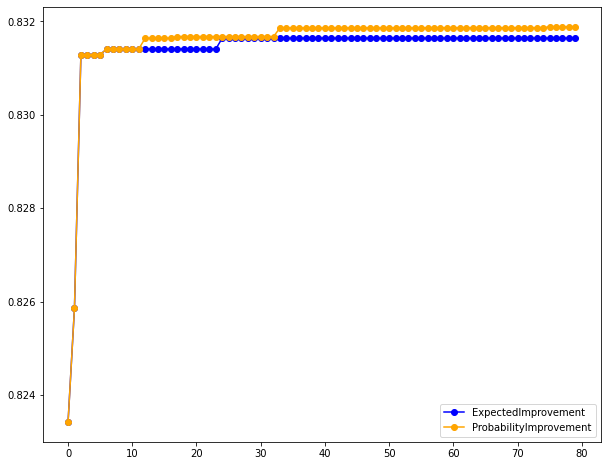

In [0]:
#ndcg_exp = np.maximum.accumulate(SMBO_exp.GP.y)
#ndcg_prob = np.maximum.accumulate(SMBO_prob.GP.y)

ndcg_exp = np.maximum.accumulate(result_exp["ndcg"])
ndcg_prob = np.maximum.accumulate(result_prob["ndcg"])

plt.figure(figsize=(10,8))
plt.plot(ndcg_exp,marker='o',color='blue',label="ExpectedImprovement")
plt.plot(ndcg_prob,marker='o',color='orange',label="ProbabilityImprovement")
plt.legend()
plt.savefig("/content/drive/My Drive/AML/Progetto/AutoML.png")

## AutoML NN

In [0]:
n_classes = len(np.unique(data["country_destination"]))
n_features = data.shape[1] - 2 

In [0]:
def resultDataframe(hyperparams, score, initial):
  result = pd.DataFrame(hyperparams,columns=['lr','n_neuron', 'n_neuron1', 'n_layers', 'n_batch_size'])
  result['ndcg'] = score
  result['phase']="increment"
  result.loc[0:initial-1,'phase']='initial'
  return result

In [0]:
def create_model(n_neuron, n_neuron1, n_layers): #, drop):
    model = models.Sequential()

    model.add(layers.Dense(int(n_neuron), input_dim=n_features, activation="relu"))
    for i in range(int(n_layers)):
        model.add(layers.Dense(int(n_neuron1), activation="relu"))

    model.add(layers.Dense(n_classes, activation="softmax"))
    
    return model

In [0]:
range_lr = [0.0001, 0.01]
range_neuron = [256, 1024]
range_neuron1 = [16, 1024]
range_layers = [0, 3]
range_batch_size = [1, 128]


param = {'lr': ('cont', range_lr), 
         'n_neuron': ('int', range_neuron),
         'n_neuron1' : ('int', range_neuron1),
         'n_layers' : ('int', range_layers),
         'n_batch_size' : ('int', range_batch_size)
         }

rf_model = RandomForest()

f_acq = Acquisition(mode = "ExpectedImprovement")
f_acq1 = Acquisition(mode = "ProbabilityImprovement") 

### Cross Validation

In [0]:
data_prova = data.copy()

In [0]:
data_prova.drop("id", axis = 1, inplace = True)

In [0]:
X_train_cval, X_test = train_test_split(data_prova, test_size = 0.1, stratify = data_prova["country_destination"], random_state = 42)

In [0]:
y_train = X_train_cval.pop("country_destination")
y_test = X_test.pop("country_destination")

In [0]:
n_classes = len(np.unique(y_train))
n_features = X_train_cval.shape[1]

In [0]:
Kfold = StratifiedKFold(5, shuffle=True, random_state=42)

In [0]:
label_encoder = LabelEncoder()
encoded_y_train = label_encoder.fit_transform(y_train)
encoded_y_test = label_encoder.fit_transform(y_test)

In [0]:
# Definizione Early Stopping
es = callbacks.EarlyStopping(monitor='loss',
                              min_delta=0,
                              patience=3,
                              verbose=0, mode='auto')

In [0]:
def compute_ndcg(lr, n_neuron, n_neuron1, n_layers, n_batch_size): # drop

    model = create_model(n_neuron, n_neuron1, n_layers) #, drop)

    model.compile(optimizer=optimizers.adam(learning_rate = lr),
                  loss='sparse_categorical_crossentropy',
                  metrics=["acc"])
    
    cval_score = []
    i = 1
    for train_index, test_index in Kfold.split(X_train_cval, encoded_y_train):
        
        X_train, X_val = X_train_cval.values[train_index], X_train_cval.values[test_index]
        y_train, y_val = encoded_y_train[train_index], encoded_y_train[test_index]

        class_weights = class_weight.compute_class_weight('balanced', 
                                                          np.unique(y_train), y_train)
        
        model.fit(X_train, y_train, 
                  batch_size = int(n_batch_size),
                  epochs = 100,
                  class_weight = class_weights,
                  callbacks = [es],
                  verbose = 0)
        
        y_pred_prob = model.predict(X_val)
        actual = ndcg_score(y_val, y_pred_prob, k = 5)
        cval_score.append(actual)
        print("Numero Fold: " + str(i))
        i = i+1
        
    print(np.mean(cval_score))
    return np.mean(cval_score)

In [0]:
np.random.seed(42)

SMBO_exp_nn = GPGO(rf_model, f_acq,
                compute_ndcg,
                param, n_jobs = -1)
SMBO_exp_nn.run(init_evals=10,
             max_iter=70)

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
Numero Fold: 1
Numero Fold: 2
Numero Fold: 3
Numero Fold: 4
Numero Fold: 5
0.8067688441906558
Numero Fold: 1
Numero Fold: 2
Numero Fold: 3
Numero Fold: 4
Numero Fold: 5
0.8067728408027222
Numero Fold: 1
Numero Fold: 2
Numero Fold: 3
Numero Fold: 4
Numero Fold: 5
0.8065815647805792
Numero Fold: 1


KeyboardInterrupt: ignored

In [0]:
# I risultati migliori vengono mandati tramite telegram
telegram_bot_sendtext("Per NN con f acq exp gli iperparametri migliori risultano : " + str(SMBO_exp_nn.getResult()[0]) + "." + "\n\n" + "E l'NDCG è pari a: " + str(SMBO_exp_nn.getResult()[1]))

In [0]:
# Vengono salvati i risultati in un dataframe
result = resultDataframe(SMBO_exp_nn.GP.X, SMBO_exp_nn.GP.y, initial=10)
result.to_csv("/content/drive/My Drive/AML/Progetto/risultati_SMBO_exp_nn.csv", index=False)

In [0]:
#Funzione di acquizione probability improvement

np.random.seed(42)

SMBO_prob_nn = GPGO(rf_model, f_acq1,
                compute_ndcg,
                param, n_jobs = 1)
SMBO_prob_nn.run(init_evals=10,
             max_iter=70)

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
Numero Fold: 1
Numero Fold: 2
Numero Fold: 3
Numero Fold: 4
Numero Fold: 5
0.8067688441906558
Numero Fold: 1
Numero Fold: 2
Numero Fold: 3
Numero Fold: 4
Numero Fold: 5
0.8067657169446889
Numero Fold: 1
Numero Fold: 2
Numero Fold: 3
Numero Fold: 4
Numero Fold: 5
0.8065876060518719
Numero Fold: 1
Numero Fold: 2
Numero Fold: 3


KeyboardInterrupt: ignored

In [0]:
telegram_bot_sendtext("Per XGBoost con f acq prob gli iperparametri migliori risultano : " + str(SMBO_prob_nn.getResult()[0]) + "." + "\n\n" + "E l'NDCG è pari a: " + str(SMBO_prob_nn.getResult()[1]))

In [0]:
# Vengono salvati i risultati in un dataframe
result = resultDataframe(SMBO_prob_nn.GP.X, SMBO_prob_nn.GP.y, initial=10)
result.to_csv("/content/drive/My Drive/AML/Progetto/risultati_SMBO_prob_nn.csv", index=False)

### Validation normale

In [0]:
data_prova = data.copy()

In [0]:
data_prova.drop("id", axis = 1, inplace = True)

In [0]:
train, test = train_test_split(data_prova, test_size = 0.1, stratify = data_prova["country_destination"], random_state = 42)

In [0]:
# Definizione Early Stopping
es = callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')

In [0]:
def compute_ndcg(lr, n_neuron, n_neuron1, n_layers, n_batch_size):

    model = create_model(n_neuron, n_neuron1, n_layers)

    model.compile(optimizer=optimizers.adam(learning_rate = lr),
                  loss='sparse_categorical_crossentropy',
                  metrics=["acc"])
    
    X_train, X_test = train_test_split(train, test_size = 0.15, stratify = train["country_destination"], random_state = 42)
    y_train = X_train.pop("country_destination")
    y_test = X_test.pop("country_destination")
    label_encoder = LabelEncoder()
    encoded_y_train = label_encoder.fit_transform(y_train)
    encoded_y_test = label_encoder.fit_transform(y_test)


    class_weights = class_weight.compute_class_weight('balanced', 
                                                        np.unique(y_train), y_train)
    
    model.fit(X_train, encoded_y_train, 
              batch_size = int(n_batch_size),
              epochs = 100,
              class_weight = class_weights,
              validation_split = 0.2,
              callbacks = [es],
              verbose = 0)
    
    y_pred_prob = model.predict(X_test)
    score = ndcg_score(encoded_y_test, y_pred_prob, k = 5)

    return score

In [0]:
np.random.seed(42)

SMBO_exp_nn = GPGO(rf_model, f_acq,
                   compute_ndcg,
                   param, n_jobs = 1)
SMBO_exp_nn.run(init_evals=10,
                max_iter=70)

In [0]:
# I risultati migliori vengono mandati tramite telegram
telegram_bot_sendtext("Per NN con f acq exp gli iperparametri migliori risultano : " + str(SMBO_exp_nn.getResult()[0]) + "." + "\n\n" + "E l'NDCG è pari a: " + str(SMBO_exp_nn.getResult()[1]))

In [0]:
# Vengono salvati i risultati in un dataframe
result = resultDataframe(SMBO_exp_nn.GP.X, SMBO_exp_nn.GP.y, initial=10)
result.to_csv("/content/drive/My Drive/AML/Progetto/risultati_SMBO_exp_nn.csv", index=False)

In [0]:
#Funzione di acquizione probability improvement

np.random.seed(42)

SMBO_prob_nn = GPGO(rf_model, f_acq1,
                compute_ndcg,
                param, n_jobs = 1)
SMBO_prob_nn.run(init_evals=10,
             max_iter=70)

In [0]:
telegram_bot_sendtext("Per NN con f acq prob gli iperparametri migliori risultano : " + str(SMBO_prob_nn.getResult()[0]) + "." + "\n\n" + "E l'NDCG è pari a: " + str(SMBO_prob_nn.getResult()[1]))

In [0]:
# Vengono salvati i risultati in un dataframe
result = resultDataframe(SMBO_prob_nn.GP.X, SMBO_prob_nn.GP.y, initial=10)
result.to_csv("/content/drive/My Drive/AML/Progetto/risultati_SMBO_prob_nn.csv", index=False)

### Confronto risultati


In [0]:
exp = pd.read_csv("/content/drive/My Drive/progetto_aml/risultati_AUTOML/risultati_SMBO_exp_nn.csv")
prob = pd.read_csv("/content/drive/My Drive/progetto_aml/risultati_AUTOML/risultati_SMBO_prob_nn.csv")

In [0]:
prob.sort_values(by="ndcg", ascending=False)

,lr,n_neuron,n_neuron1,n_layers,n_batch_size,ndcg,phase
24,0.000296,797.0,724.0,2.0,62.0,0.827999,increment
27,0.000323,686.0,295.0,2.0,17.0,0.827950,increment
79,0.001947,304.0,664.0,2.0,127.0,0.825028,increment
68,0.003654,499.0,347.0,2.0,121.0,0.824183,increment
12,0.001133,832.0,408.0,1.0,108.0,0.823867,increment
...,...,...,...,...,...,...,...
31,0.000450,351.0,617.0,2.0,71.0,0.806459,increment
76,0.001323,682.0,1002.0,1.0,60.0,0.805889,increment
30,0.000203,820.0,469.0,2.0,52.0,0.801012,increment
21,0.000154,758.0,693.0,1.0,123.0,0.699102,increment


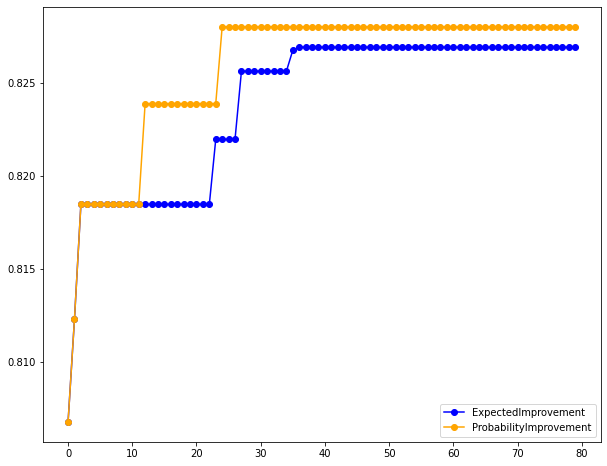

In [0]:
ndcg_exp_nn = np.maximum.accumulate(exp["ndcg"])
ndcg_prob_nn = np.maximum.accumulate(prob["ndcg"])

plt.figure(figsize=(10,8))
plt.plot(ndcg_exp_nn,marker='o',color='blue',label="ExpectedImprovement")
plt.plot(ndcg_prob_nn,marker='o',color='orange',label="ProbabilityImprovement")
plt.legend(loc=4)
plt.savefig("/content/drive/My Drive/AML/Progetto/AutoML_nn.png")